<a href="https://colab.research.google.com/github/esraaelbaz/Homonyms_Problem_NLP/blob/main/Homonyms_Problem_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Handling Homonyms in Sentiment Analysis Using Deep Learning Techniques
This project aims to develop a pipeline for sentiment analysis using deep learning models, particularly focusing on LSTM (Long Short-Term Memory) networks and the DistilBERT transformer model, to better handle homonyms and improve overall accuracy

## main steps:


*   Identify and preprocess a dataset suitable for sentiment analysis.

*   Implement deep learning models (LSTM and DistilBERT) to classify sentiments.


*   Evaluate and compare the performance of these models in handling contextual ambiguities.



# Installing & Importing Required Packages


In [ ]:
#The transformers library is used for working with transformer models like BERT
!pip install transformers
#The datasets library provides access to various datasets, and fsspec is a dependency for the datasets library.
!pip install datasets==2.13.1
!pip install fsspec==2023.9.2

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.4/173.4 kB 3.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
      Successfully uninstalled fsspec-2024.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.6.1 requires fsspec==2024.6.1, but you have fsspec 2023.9.2 which is incompatible.


In [ ]:
# importing the datasets library and printing its version
import datasets; datasets.__version__

'2.13.1'

In [ ]:
#Upgrades TensorFlow to the latest version to ensure compatibility with other libraries.
!pip install --upgrade tensorflow

In [ ]:
# counter: helpful for counting labels.
from collections import Counter

#tqdm: for tracking long-running operations by displaying bars for loops.
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#for evaluating models
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

#Imports TensorFlow and Keras, which are used for building and training neural network models.
import tensorflow as tf
from tensorflow import keras

#Tokenizer and pad_sequences: Preprocessing utilities to tokenize and pad text sequences.
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Sequential: Keras API for creating neural network models sequentially layer by layer.
from tensorflow.keras.models import Sequential

#Embedding, LSTM, Dense, Dropout: Different types of layers used in the neural network model.
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, TimeDistributed, Bidirectional

from datasets import load_dataset

#AutoTokenizer and TFAutoModelForSequenceClassification:for tokenizing text and creating a pre-trained model for sequence classification.
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

# Loading and Exploring the Dataset
  using the Stanford Sentiment Treebank (SST-2) dataset, which contains sentences labeled as positive or negative.


In [ ]:
dataset = load_dataset("sst2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/parquet/sst2-c614fb49d6bf6d65/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
#showing the structure ofthe data.
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 872
    })
    test: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 1821
    })
})


In [ ]:
print(f"The first 3 examples: ")
dataset["train"][:3]

The first 3 examples: 


{'idx': [0, 1, 2],
 'sentence': ['hide new secretions from the parental units ',
  'contains no wit , only labored gags ',
  'that loves its characters and communicates something rather beautiful about human nature '],
 'label': [0, 0, 1]}

In [ ]:
#display dataset features
print(f"Dataset features: ")
dataset["train"].features

Dataset features: 


{'idx': Value(dtype='int32', id=None),
 'sentence': Value(dtype='string', id=None),
 'label': ClassLabel(names=['negative', 'positive'], id=None)}

In [ ]:
#Extract the label Feature
labels = dataset["train"].features["label"]
print(f"labels: {labels}")

labels: ClassLabel(names=['negative', 'positive'], id=None)


# Data Preprocessing



In [ ]:
# Mapping Labels:  using the int2str method of the labels object.
#While the dataset is already quite user-friendly in terms of label names.
#this conversion is a good practice to ensure the data is comprehensible throughout the training and evaluation process.

def convert_id_to_label(example):
    """
    Convert the label ID to its corresponding class.

    Parameters
    ----------
    - example : dict
        Representing one sample of the data.

    Returns
    -------
    - dict
        Contains the new column name `label_str` with corresponding
        class name for eachs sample.
    """

    # here we can use the above `labels` object's `in2str()` method
    return {"label_str": labels.int2str(example["label"])}

In [ ]:
dataset["train"] = dataset["train"].map(convert_id_to_label, batched=True)
dataset["validation"] = dataset["validation"].map(convert_id_to_label, batched=True)
print(dataset)

Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'label', 'label_str'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['idx', 'sentence', 'label', 'label_str'],
        num_rows: 872
    })
    test: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 1821
    })
})


In [ ]:
print(f"The first example after adding label_str: ")
dataset["train"][0]
#the training and validation datasets contain a new column label_str that contains each sample's corresponding class

The first example after adding label_str: 


{'idx': 0,
 'sentence': 'hide new secretions from the parental units ',
 'label': 0,
 'label_str': 'negative'}

In [ ]:
# Convert to Pandas DataFrame for visualization data manipulation
dataset.set_format("pandas")
df_train = dataset["train"][:]
df_validation = dataset["validation"][:]

In [ ]:
df_train.head()


,idx,sentence,label,label_str
0,0,hide new secretions from the parental units,0,negative
1,1,"contains no wit , only labored gags",0,negative
2,2,that loves its characters and communicates som...,1,positive
3,3,remains utterly satisfied to remain the same t...,0,negative
4,4,on the worst revenge-of-the-nerds clichés the ...,0,negative


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67349 entries, 0 to 67348
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   idx        67349 non-null  int32 
 1   sentence   67349 non-null  object
 2   label      67349 non-null  int64 
 3   label_str  67349 non-null  object
dtypes: int32(1), int64(1), object(2)
memory usage: 1.8+ MB


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67349 entries, 0 to 67348
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   idx        67349 non-null  int32 
 1   sentence   67349 non-null  object
 2   label      67349 non-null  int64 
 3   label_str  67349 non-null  object
dtypes: int32(1), int64(1), object(2)
memory usage: 1.8+ MB


In [ ]:
dataset.set_format("pandas")
df_train = dataset["train"][:]
df_train.to_csv("/content/train")

In [ ]:
df_validation = dataset["validation"][:]
df_validation.to_csv("/content/validation")

In [ ]:
df_train = pd.read_csv("/content/train", index_col=0)
df_validation = pd.read_csv("/content/validation", index_col=0)

In [ ]:
df_train.head()


,idx,sentence,label,label_str
0,0,hide new secretions from the parental units,0,negative
1,1,"contains no wit , only labored gags",0,negative
2,2,that loves its characters and communicates som...,1,positive
3,3,remains utterly satisfied to remain the same t...,0,negative
4,4,on the worst revenge-of-the-nerds clichés the ...,0,negative


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 67349 entries, 0 to 67348
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   idx        67349 non-null  int64 
 1   sentence   67349 non-null  object
 2   label      67349 non-null  int64 
 3   label_str  67349 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.6+ MB


#Checking Class Imbalance


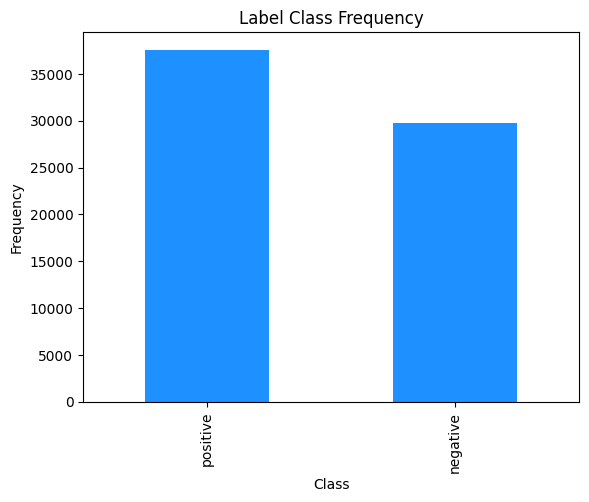

In [ ]:
df_train["label_str"].value_counts().plot.bar(color="dodgerblue")
plt.title("Label Class Frequency")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

Observing a slight class imbalance, I plan to train two LSTM models, one before addressing this imbalance and another after making adjustments.

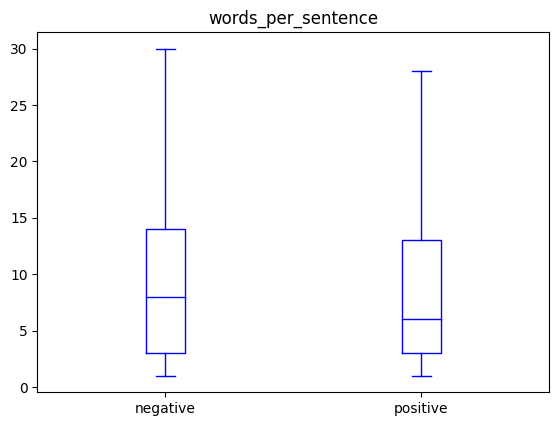

In [ ]:
#Checking the Maximum Words Per Sentence: by creating a box plot to show the distribution of sentence lengths for each class.
df_train["words_per_sentence"] = df_train["sentence"].str.split().apply(len)
df_train.boxplot("words_per_sentence", by="label_str", color="blue", grid=False, showfliers=False)
plt.suptitle("")
plt.xlabel("")
plt.show()

#Text tokenization:
A Tokenizer from keras is used to convert text into sequences of integers, where each integer represents a word in the vocabulary



In [ ]:
# Instantiate a `tokenizer` object to convert text to integers to build the vocabulary, which maps each word to a unique integer.
tokenizer = Tokenizer()
# Fittng the tokenizer on the training data
tokenizer.fit_on_texts(df_train['sentence'])

train_sequences = tokenizer.texts_to_sequences(df_train['sentence'])
valid_sequences = tokenizer.texts_to_sequences(df_validation['sentence'])

In [ ]:
#etrieving a dictionary mapping of words to their respective integer, assiging an integer index to each unique word based on its frequency.
word2idx = tokenizer.word_index

# The reason for adding one to be able to map the [padding token]
vocab_size = len(word2idx) + 1

print(f"Total vocab size: {vocab_size}")

Total vocab size: 13823


#Padding the Sequences to Maximum Sentence Length

The sequences are padded to ensure uniform length for input to the model which is cruical.


In [ ]:
#chooses the largest value (Maximum sequence length) to ensure no data is lost or excessively padded during preprocessing.

max_train_sequence_length = max(len(seq) for seq in train_sequences)
max_valid_sequence_length = max(len(seq) for seq in valid_sequences)

print(f"Maximum number of words in training data: {max_train_sequence_length}")
print(f"Maximum number of words in validation data: {max_valid_sequence_length}")

max_sequence_length = max(max_train_sequence_length, max_valid_sequence_length)
print(f"Maximum sequence length: {max_sequence_length}")

train_padded_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post')
valid_padded_sequences = pad_sequences(valid_sequences, maxlen=max_sequence_length, padding='post')

print(f"Train padded sequence shape: {train_padded_sequences.shape}")
print(f"Validation padded sequence shape: {valid_padded_sequences.shape}")

Maximum number of words in training data: 49
Maximum number of words in validation data: 43
Maximum sequence length: 49
Train padded sequence shape: (67349, 49)
Validation padded sequence shape: (872, 49)


#Models Building


###Fixed-Embeddings LSTM Base Model (Imbalance)

In [ ]:
# Define multiple values to do a simple grid search (hyperparameters in neural network models. Their selection is crucial for model performance
#Grid Search tries every possible combination of hyperparameters, ensuring that we don't miss any potentially good configuration.

embedding_dims = [64, 128, 512, 768] #the size of the vector space in which words or tokens are represented.

hidden_dims = [32, 64, 128]
output_dim = 2

# These hyperparameters remains constant during the grid search (num_epochs & batch_size)
num_epochs = 5
batch_size = 32


def create_lstm_model(embedding_dim, hidden_dim):
    """
    Instantiate a `keras.Sequential` model with the specific
    `embedding_dim` and `hidden_dim`.

    Parameters
    ----------
    - embedding_dim : int
        Defines the embedding dimension for each word.

    - hidden_dim : int
        Defines the number of hidden units in the LSTM cell.

    Returns
    -------
    - model : keras.Sequential
        a Sequential model.
    """

    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
    model.add(LSTM(hidden_dim))
    model.add(Dropout(0.01))
    model.add(Dense(output_dim, activation="softmax"))

    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    return model

### Find Optimal Hyperparameters Function

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding

#This function trains and evaluates an LSTM model using different combinations of embedding dimensions and hidden dimensions.
#For each combination, it calculates and stores the validation loss and accuracy.
#Finally, it returns the results, which can be used to identify the best set of hyperparameters for the model.
def find_best_hyperparamters():
    """
    Using grid search to search for a specific set of optimal
    hyperparameters.

    Returns
    -------
    - tuple[dict, dict]
        It returns all validation losses & accuracies values for each model
        trained on specific set of hyperparameters.
    """

    i = 0
    all_val_losses = {}
    all_val_accuracies = {}

#Loops through each value in the embedding_dims list. This represents the dimension of the word embeddings to be tested.
    for embedding_dim in embedding_dims:
        for hidden_dim in hidden_dims: #Nested loop that iterates over each value in the hidden_dims list
            print(f"model {i+1}:")     #Printing the model number to the console. This helps in tracking the progress of the grid search.
            model = create_lstm_model(embedding_dim, hidden_dim)
            model.fit(train_padded_sequences, df_train["label"], epochs=num_epochs,
                      batch_size=batch_size, validation_data=(valid_padded_sequences, df_validation["label"]))
            val_loss, val_accuracy = model.evaluate(valid_padded_sequences, df_validation['label'])

            all_val_losses[(embedding_dim, hidden_dim)] = val_loss
            all_val_accuracies[(embedding_dim, hidden_dim)] = val_accuracy
            i += 1
            print()
            print(f"=" * 100)

    print(f"all_val_losses: \n{all_val_losses}")
    print(f"all_val_accuracies: \n{all_val_accuracies}")

    return all_val_losses, all_val_accuracies

In [ ]:
all_val_losses, all_val_accuracies = find_best_hyperparamters()

model 1:


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 79s 34ms/step - accuracy: 0.5619 - loss: 0.6749 - val_accuracy: 0.6250 - val_loss: 0.6576
Epoch 2/5
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 79s 33ms/step - accuracy: 0.6446 - loss: 0.6505 - val_accuracy: 0.6112 - val_loss: 0.6689
Epoch 3/5
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 64s 30ms/step - accuracy: 0.6321 - loss: 0.6593 - val_accuracy: 0.6204 - val_loss: 0.6678
Epoch 4/5
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 62s 30ms/step - accuracy: 0.6433 - loss: 0.6517 - val_accuracy: 0.6078 - val_loss: 0.6772
Epoch 5/5
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 82s 29ms/step - accuracy: 0.6569 - loss: 0.6404 - val_accuracy: 0.6491 - val_loss: 0.6560
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6795 - loss: 0.6302

model 2:
Epoch 1/5
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 81s 38ms/step - accuracy: 0.5614 - loss: 0.6857 - val_accuracy: 0.5092 - val_loss: 0.7072
Epoch 2/5
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 77s 36ms/step - accuracy: 0.5702 - loss: 0.6746 - val_accuracy: 0.5092 - val_loss: 0.6836


### Visualizing Hyperparameters


In [ ]:
#creating DataFrame from the hyperparameter tuning results and sort it by validation accuracy in descending order to identify the best-performing models.

hyperparameters_combinations = list(all_val_losses.keys())
all_val_losses_values = list(all_val_losses.values())
all_val_accuracies_values = list(all_val_accuracies.values())

hyperparam_data = {
    "combination": hyperparameters_combinations,
    "validation loss": all_val_losses_values,
    "validation accuracy": all_val_accuracies_values
}

hyperparam_df = pd.DataFrame(hyperparam_data)
hyperparam_df.sort_values("validation accuracy", ascending=False)

,combination,validation loss,validation accuracy
8,"(512, 128)",0.378509,0.844037
7,"(512, 64)",0.470780,0.833716
6,"(512, 32)",0.428965,0.832569
9,"(768, 32)",0.462366,0.832569
3,"(128, 32)",0.412669,0.831422
11,"(768, 128)",0.538979,0.825688
10,"(768, 64)",0.532174,0.822248
4,"(128, 64)",0.468897,0.814220
2,"(64, 128)",0.458517,0.809633
0,"(64, 32)",0.641629,0.675459


<Figure size 1000x1000 with 0 Axes>

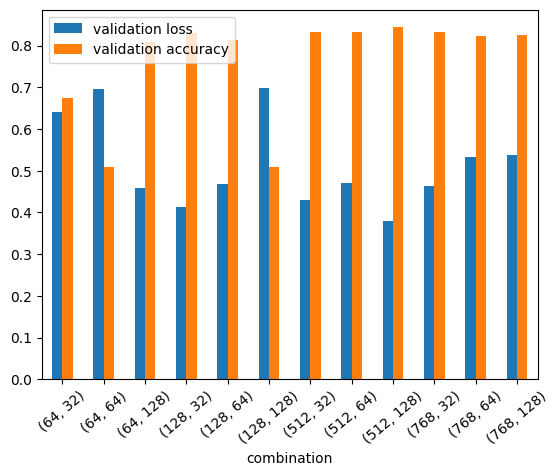

In [ ]:
plt.figure(figsize=(10, 10))
hyperparam_df.set_index("combination").plot.bar()
plt.xticks(rotation=40)
plt.show()

In [ ]:
hyperparam_df.loc[hyperparam_df['validation accuracy'] == hyperparam_df['validation accuracy'].max()]


,combination,validation loss,validation accuracy
8,"(512, 128)",0.378509,0.844037


#### **Note**;  the optimal hyperparameter achieving the best validation accuracy are: 512 and 128 for embedding_dim and hidden_dim respectievly

#Training a Model with Optimal Hyperparameters

traingthe LSTM model using the best set of hyperparameters.
This should give the best performance on the validation set, as the model is trained with the hyperparameters that achieved the highest validation accuracy during grid search.



In [ ]:
optimal_embedding_dim = 512
optimal_hidden_dim = 128
lstm_model = create_lstm_model(optimal_embedding_dim, optimal_hidden_dim)
history = lstm_model.fit(train_padded_sequences, df_train["label"], epochs=num_epochs,
                    batch_size=batch_size, validation_data=(valid_padded_sequences, df_validation["label"]))

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2105/2105 ━━━━━━━━━━━━━━━━━━━━ 27s 12ms/step - accuracy: 0.5538 - loss: 0.6884 - val_accuracy: 0.5092 - val_loss: 0.6989
Epoch 2/5
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - accuracy: 0.5551 - loss: 0.6881 - val_accuracy: 0.5092 - val_loss: 0.6975
Epoch 3/5
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - accuracy: 0.5677 - loss: 0.6792 - val_accuracy: 0.7901 - val_loss: 0.4640
Epoch 4/5
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - accuracy: 0.8917 - loss: 0.2728 - val_accuracy: 0.8154 - val_loss: 0.4390
Epoch 5/5
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - accuracy: 0.9495 - loss: 0.1371 - val_accuracy: 0.8475 - val_loss: 0.4207


#Model Results

In [ ]:
def plot_loss(history, model_type):
    """
    Plot training and validation loss curves for a Keras model.

    Parameters
    ----------
    - history : keras.callbacks.History
        The training history of a Keras model.

    - model_type : str
        A string indicating the type or name of the model.
    """

    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Training Loss Vs. Validation Loss " + model_type)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


def plot_accuracy(history, model_type):
    """
    Plot training and validation accuracy curves for a Keras model.

    Parameters
    ----------
    - history : keras.callbacks.History
        The training history of a Keras model.

    - model_type : str
        A string indicating the type or name of the model.
    """

    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title("Training Accuracy Vs. Validation Accuracy " + model_type)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


def plot_confusion_matrix(y_preds, y_true, labels, model_type):
    """
    Plot a normalized confusion matrix for classification results.

    Parameters
    ----------
    - y_preds : array-like of shape (n_samples,)
        Predicted labels.

    - y_true : array-like of shape (n_samples,)
        True labels.

    - labels : list
        List of class labels.

    - model_type : str
        A string indicating the type or name of the model.
    """

    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized Confusion Matrix " + model_type)
    plt.show()


def print_classification_report(y_preds, y_true):
    """
    Display classification report for classification results.

    Parameters
    ----------
    - y_preds : array-like of shape (n_samples,)
        Predicted labels.

    - y_true : array-like of shape (n_samples,)
        True labels.
    """

    clf = classification_report(y_true, y_preds)
    print(clf)

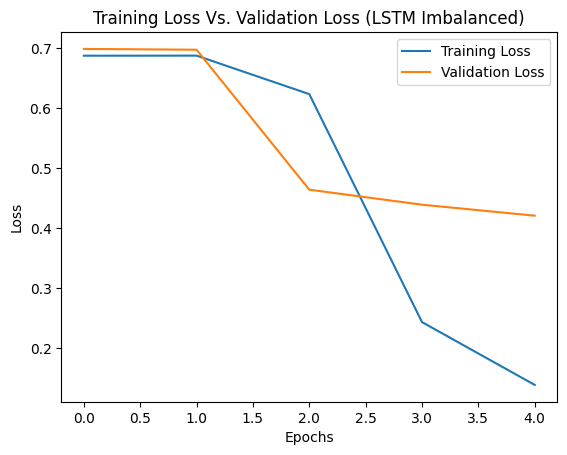

In [ ]:
plot_loss(history, "(LSTM Imbalanced)")


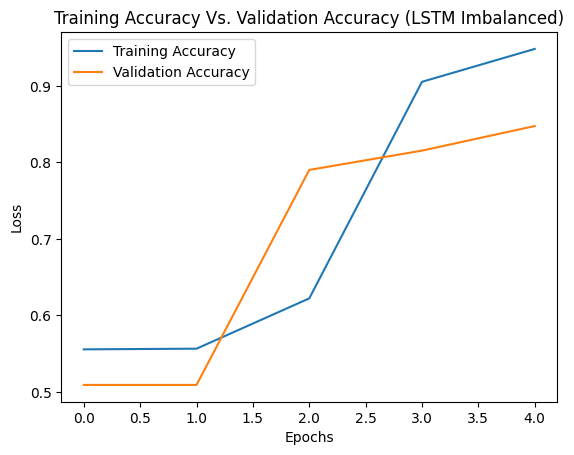

In [ ]:
plot_accuracy(history, "(LSTM Imbalanced)")


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


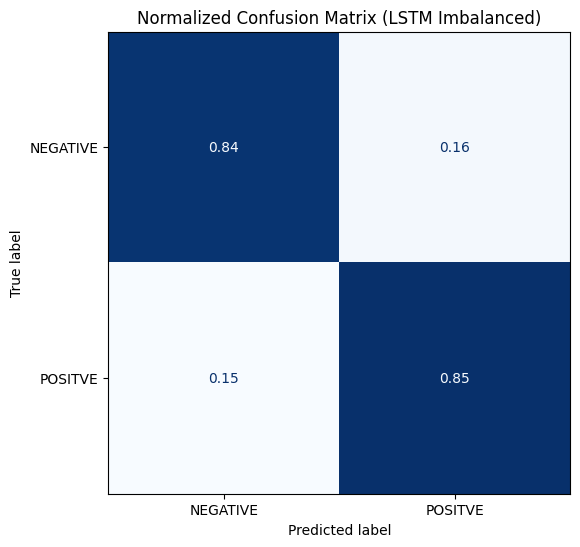

In [ ]:
y_pred = lstm_model.predict(valid_padded_sequences).argmax(axis=1)
plot_confusion_matrix(y_pred, df_validation["label"], ["NEGATIVE", "POSITVE"], "(LSTM Imbalanced)")

**Precision:** The ratio of true positive predictions to the total number of positive predictions made by the model.

High precision means that fewer false positives.


**Recall:** The ratio of true positive predictions to the total number of actual positives in the dataset.

High recall means that the model is capturing most of the actual positives, with fewer false negatives.

**F1-Score:** The harmonic mean of precision and recall, providing a single metric to balance both precision and recall.

**Support:** The number of actual occurrences of each class in the dataset.

In [ ]:
print_classification_report(y_pred, df_validation["label"])

              precision    recall  f1-score   support

           0       0.85      0.84      0.84       428
           1       0.85      0.85      0.85       444

    accuracy                           0.85       872
   macro avg       0.85      0.85      0.85       872
weighted avg       0.85      0.85      0.85       872



#Model Testing

In [ ]:
val_loss, val_accuracy = lstm_model.evaluate(valid_padded_sequences, df_validation['label'])
print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy * 100:.2f}%")

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8546 - loss: 0.4168
Validation Loss: 0.4207 | Validation Accuracy: 84.75%


In [ ]:
def predict(model, tokenizer, text):
    """
    Predict sentiment label and score for a given text using a Keras `model`.

    Parameters
    ----------
    - model : keras.Model
        The trained Keras model for sentiment analysis.

    - tokenizer : keras.preprocessing.text.Tokenizer
        The tokenizer used for preprocessing the text.

    - text : str
        The input text for sentiment prediction.

    Returns
    -------
    dict
        A dictionary containing the predicted sentiment label and score.
        Example: {"label": "POSITIVE", "score": 0.85}
    """

    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length, padding='post')
    prediction = model.predict(padded_sequence)

    label = "POSITIVE" if prediction.argmax() else "NEGATIVE"
    score = prediction[0, 1] if prediction.argmax() else prediction[0, 0]

    return {"label": label, "score": score}

In [ ]:
#For Quick Feedback make a test cases and use it to quickly understand the model behavior
test_cases = [
    {"text": "I love you", "label": "POSITIVE"},
    {"text": "I hate you", "label": "NEGATIVE"},
    {"text": "I hate the selfishness in you", "label": "NEGATIVE"},
    {"text": "I hate anyone hurts you", "label": "POSITIVE"},
    {"text": "I hate anyone hurting you", "label": "POSITIVE"},
    {"text": "I hate anyone hurting you, you are my partner", "label": "POSITIVE"},
    {"text": "I hate anyone hurting you, you are my love", "label": "POSITIVE"},
    {"text": "I like rude people", "label": "NEGATIVE"},
    {"text": "I don't like rude people", "label": "POSITIVE"},
    {"text": "I hate polite people", "label": "NEGATIVE"},
    {"text": "I don't hate polite people", "label": "POSITIVE"},
]

test_cases_df = pd.DataFrame(test_cases)
test_cases_df

,text,label
0,I love you,POSITIVE
1,I hate you,NEGATIVE
2,I hate the selfishness in you,NEGATIVE
3,I hate anyone hurts you,POSITIVE
4,I hate anyone hurting you,POSITIVE
5,"I hate anyone hurting you, you are my partner",POSITIVE
6,"I hate anyone hurting you, you are my love",POSITIVE
7,I like rude people,NEGATIVE
8,I don't like rude people,POSITIVE
9,I hate polite people,NEGATIVE


In [ ]:
predicted_labels = []
predicted_scores = []

for row in test_cases_df.values:
    prediction = predict(lstm_model, tokenizer, row[0])
    predicted_labels.append(prediction["label"])
    predicted_scores.append(prediction["score"])

test_cases_df["lstm_predicted_label"] = predicted_labels
test_cases_df["lstm_predicted_score"] = predicted_scores
test_cases_df

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


,text,label,lstm_predicted_label,lstm_predicted_score
0,I love you,POSITIVE,POSITIVE,0.994703
1,I hate you,NEGATIVE,NEGATIVE,0.739652
2,I hate the selfishness in you,NEGATIVE,NEGATIVE,0.954490
3,I hate anyone hurts you,POSITIVE,NEGATIVE,0.990364
4,I hate anyone hurting you,POSITIVE,NEGATIVE,0.962492
5,"I hate anyone hurting you, you are my partner",POSITIVE,NEGATIVE,0.596858
6,"I hate anyone hurting you, you are my love",POSITIVE,POSITIVE,0.788902
7,I like rude people,NEGATIVE,NEGATIVE,0.966719
8,I don't like rude people,POSITIVE,NEGATIVE,0.966719
9,I hate polite people,NEGATIVE,NEGATIVE,0.986881


A notable observation pertains to the sentence "I hate anyone hurting you, you are my partner" Despite an incorrect label, the model exhibits a relatively lower confidence score. This suggests the model's attempt to refine its comprehension by incorporating supplementary elements, such as "you are my love" in an effort to gain a more nuanced understanding of the sentence.

#Balancing the Dataset

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

X = train_padded_sequences
y = df_train["label"]
print(f"Original label counts:\n{Counter(y)}\n")

rus = RandomUnderSampler(random_state=42)  #Creating an Instance of RandomUnderSampler and (random_state=42) to ensure reproducibility.
X_res, y_res = rus.fit_resample(X, y)

print(f"underrsampled label counts:\n{Counter(y_res)}\n")

Original label counts:
Counter({1: 37569, 0: 29780})

underrsampled label counts:
Counter({0: 29780, 1: 29780})



#Training the Model with Optimal Hyperparameters

In [ ]:
model_balanced_ds = create_lstm_model(optimal_embedding_dim, optimal_hidden_dim)
history = model_balanced_ds.fit(X_res, y_res, epochs=num_epochs,
                    batch_size=batch_size, validation_data=(valid_padded_sequences, df_validation["label"]))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - accuracy: 0.4995 - loss: 0.6948 - val_accuracy: 0.4908 - val_loss: 0.6936
Epoch 2/5
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - accuracy: 0.5011 - loss: 0.6931 - val_accuracy: 0.5092 - val_loss: 0.6931
Epoch 3/5
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - accuracy: 0.5770 - loss: 0.6278 - val_accuracy: 0.8222 - val_loss: 0.4102
Epoch 4/5
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - accuracy: 0.9274 - loss: 0.1931 - val_accuracy: 0.8394 - val_loss: 0.4002
Epoch 5/5
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - accuracy: 0.9613 - loss: 0.1058 - val_accuracy: 0.8486 - val_loss: 0.4337


As it shown above;
Overall, The model training appears to be progressing well, especially in the later epochs

#Model Results

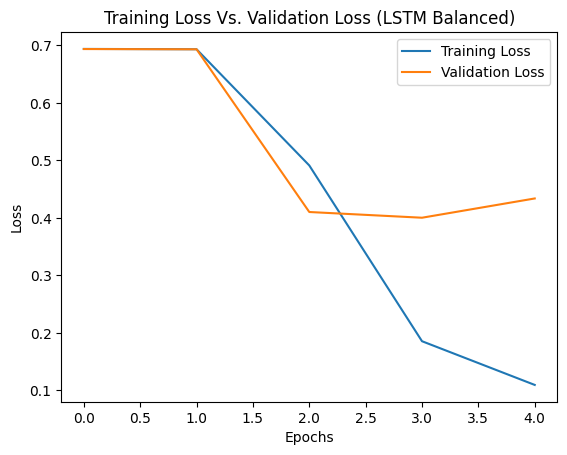

In [ ]:
plot_loss(history, "(LSTM Balanced)")

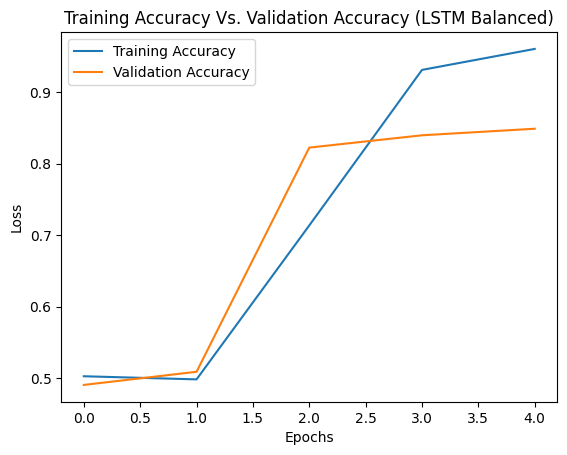

In [ ]:
plot_accuracy(history, "(LSTM Balanced)")

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


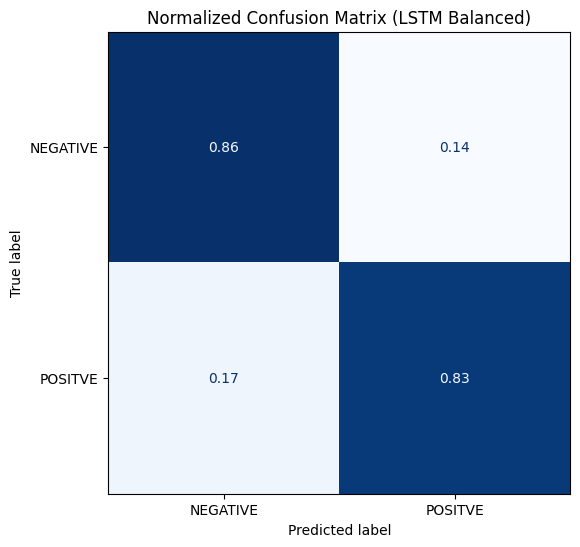

In [ ]:
y_pred = model_balanced_ds.predict(valid_padded_sequences).argmax(axis=1)
plot_confusion_matrix(y_pred, df_validation["label"], ["NEGATIVE", "POSITVE"], "(LSTM Balanced)")

In [ ]:
print_classification_report(y_pred, df_validation["label"])

              precision    recall  f1-score   support

           0       0.83      0.86      0.85       428
           1       0.86      0.83      0.85       444

    accuracy                           0.85       872
   macro avg       0.85      0.85      0.85       872
weighted avg       0.85      0.85      0.85       872



#Model Testing

In [ ]:
val_loss, val_accuracy = model_balanced_ds.evaluate(valid_padded_sequences, df_validation['label'])
print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy * 100:.2f}%")

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8479 - loss: 0.4456
Validation Loss: 0.4337 | Validation Accuracy: 84.86%


In [ ]:
predicted_labels = []
predicted_scores = []

for row in test_cases_df.values:
    prediction = predict(model_balanced_ds, tokenizer, row[0])
    predicted_labels.append(prediction["label"])
    predicted_scores.append(prediction["score"])

test_cases_df["predicted_label_balanced"] = predicted_labels
test_cases_df["predicted_score_balanced"] = predicted_scores
test_cases_df

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


,text,label,lstm_predicted_label,lstm_predicted_score,predicted_label_balanced,predicted_score_balanced
0,I love you,POSITIVE,POSITIVE,0.994703,POSITIVE,0.999149
1,I hate you,NEGATIVE,NEGATIVE,0.739652,NEGATIVE,0.740384
2,I hate the selfishness in you,NEGATIVE,NEGATIVE,0.954490,NEGATIVE,0.792428
3,I hate anyone hurts you,POSITIVE,NEGATIVE,0.990364,NEGATIVE,0.986420
4,I hate anyone hurting you,POSITIVE,NEGATIVE,0.962492,NEGATIVE,0.907950
5,"I hate anyone hurting you, you are my partner",POSITIVE,NEGATIVE,0.596858,POSITIVE,0.626283
6,"I hate anyone hurting you, you are my love",POSITIVE,POSITIVE,0.788902,POSITIVE,0.977194
7,I like rude people,NEGATIVE,NEGATIVE,0.966719,NEGATIVE,0.978400
8,I don't like rude people,POSITIVE,NEGATIVE,0.966719,NEGATIVE,0.978400
9,I hate polite people,NEGATIVE,NEGATIVE,0.986881,NEGATIVE,0.993391


#Contextual-Embeddings DistilBERT Model

In [ ]:
# reset  the dataset formating
dataset.reset_format()

In [ ]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'label', 'label_str'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['idx', 'sentence', 'label', 'label_str'],
        num_rows: 872
    })
    test: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 1821
    })
})


#Loading DistilBERT Tokenizer and Model

DistilBERT stands for "Distilled BERT." It is a smaller, faster, and lighter version of BERT (Bidirectional Encoder Representations from Transformers)


Developed by the team at Hugging Face, DistilBERT is designed to reduce the size and inference time of BERT while maintaining over 95% of its language understanding capabilities.


The decision of choosing DistilBERT over traditional BERT instances from the task's inherent simplicity, aiming for enhanced efficiency. This choice is rooted in the fact that DistilBERT offers a 40% reduction in memory requirements (67 million parameters) compared to the standard BERT base (110 million parameters), all while maintaining a relatively high level of performance. This strategic selection aligns with the task's straightforward nature, capitalizing on the efficiency gains achieved by leveraging a more lightweight yet effective model in the form of DistilBERT

In [ ]:
model_ckpt = "distilbert-base-cased"

#Loading the Tokenizer and the Model
distilbert_tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
distilbert_model = TFAutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=labels.num_classes)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [ ]:
def tokenize(batch, tokenizer):
    """
    Tokenize a batch of sentences using a given `tokenizer`.

    Parameters
    ----------
    - batch : dict
        A dictionary containing a key 'sentence' with a list of sentences.

    - tokenizer : transformers.AutoTokenizer
        The tokenizer used for tokenization.

    Returns
    -------
    dict
        A dictionary containing the tokenized sequences with padding and truncation.
    """

    return tokenizer(batch["sentence"], padding=True, truncation=True)

dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None, fn_kwargs={"tokenizer": distilbert_tokenizer})

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

In [ ]:
print(f"Dataset after encoding:")
print(dataset_encoded)

Dataset after encoding:
DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'label', 'label_str', 'input_ids', 'attention_mask'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['idx', 'sentence', 'label', 'label_str', 'input_ids', 'attention_mask'],
        num_rows: 872
    })
    test: Dataset({
        features: ['idx', 'sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1821
    })
})


##Converting Hugging Face Dataset object to TF.Dataset

In [ ]:
# Choose only the ['input_ids', 'attention_mask']
tokenizer_columns = distilbert_tokenizer.model_input_names

tf_train_dataset = dataset_encoded["train"].to_tf_dataset(
    columns=tokenizer_columns, label_cols=["label"], shuffle=True,
    batch_size=batch_size)

tf_valid_dataset = dataset_encoded["validation"].to_tf_dataset(
    columns=tokenizer_columns, label_cols=["label"], shuffle=False,
    batch_size=batch_size)

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:385: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


##Model Compiling

In [ ]:
distilbert_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"])

##Model Fine-Tuning

In [ ]:
history = distilbert_model.fit(tf_train_dataset, validation_data=tf_valid_dataset, epochs=3)

Epoch 1/3
2105/2105 [==============================] - 504s 230ms/step - loss: 0.2492 - accuracy: 0.8962 - val_loss: 0.2590 - val_accuracy: 0.9094
Epoch 2/3
2105/2105 [==============================] - 479s 227ms/step - loss: 0.1365 - accuracy: 0.9507 - val_loss: 0.2856 - val_accuracy: 0.9083
Epoch 3/3
2105/2105 [==============================] - 479s 227ms/step - loss: 0.0960 - accuracy: 0.9659 - val_loss: 0.2778 - val_accuracy: 0.9025


##Model Results

28/28 [==============================] - 3s 69ms/step


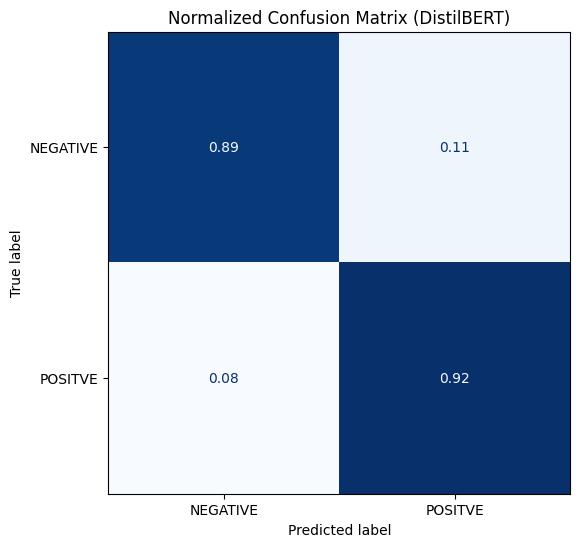

In [ ]:
y_pred = distilbert_model.predict(tf_valid_dataset).logits.argmax(axis=1)
plot_confusion_matrix(y_pred, df_validation["label"], ["NEGATIVE", "POSITVE"], "(DistilBERT)")

In [ ]:
print_classification_report(y_pred, df_validation["label"])

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       428
           1       0.89      0.92      0.91       444

    accuracy                           0.90       872
   macro avg       0.90      0.90      0.90       872
weighted avg       0.90      0.90      0.90       872



As it shown above:
Overall, the DistilBERT model provides robust and reliable predictions, with a high level of accuracy and balanced performance across both classes.

#Model Testing

In [ ]:
val_loss, val_accuracy = distilbert_model.evaluate(tf_valid_dataset)
print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy * 100:.2f}%")

28/28 [==============================] - 2s 72ms/step - loss: 0.2778 - accuracy: 0.9025
Validation Loss: 0.2778 | Validation Accuracy: 90.25%


In [ ]:
def softmax(x):
    """
    Compute softmax values for a set of scores.

    Parameters
    ----------
    - x : numpy.ndarray
        Array containing the input scores.

    Returns
    -------
    numpy.ndarray
        Array containing the softmax values.
    """

    return np.exp(x) / np.sum(np.exp(x), axis=0)

In [ ]:
predicted_labels = []
predicted_scores = []

for row in test_cases_df.values:
    inputs = distilbert_tokenizer(row[0], padding=True, truncation=True)
    logits = distilbert_model.predict(inputs["input_ids"]).logits
    scores = softmax(logits[0])

    label = "POSITIVE" if scores.argmax() else "NEGATIVE"
    score = scores[1] if scores.argmax() else scores[0]

    predicted_labels.append(label)
    predicted_scores.append(score)

test_cases_df["predicted_label_distilbert"] = predicted_labels
test_cases_df["predicted_score_distilbert"] = predicted_scores
test_cases_df

1/1 [==============================] - 0s 41ms/step


,text,label,lstm_predicted_label,lstm_predicted_score,predicted_label_balanced,predicted_score_balanced,predicted_label_distilbert,predicted_score_distilbert
0,I love you,POSITIVE,POSITIVE,0.994703,1,0.998183,POSITIVE,0.999224
1,I hate you,NEGATIVE,NEGATIVE,0.739652,0,0.912598,NEGATIVE,0.990159
2,I hate the selfishness in you,NEGATIVE,NEGATIVE,0.954490,0,0.999308,NEGATIVE,0.986115
3,I hate anyone hurts you,POSITIVE,NEGATIVE,0.990364,0,0.999851,NEGATIVE,0.931931
4,I hate anyone hurting you,POSITIVE,NEGATIVE,0.962492,0,0.999753,NEGATIVE,0.951622
5,"I hate anyone hurting you, you are my partner",POSITIVE,NEGATIVE,0.596858,0,0.989368,POSITIVE,0.901030
6,"I hate anyone hurting you, you are my love",POSITIVE,POSITIVE,0.788902,0,0.850900,POSITIVE,0.941926
7,I like rude people,NEGATIVE,NEGATIVE,0.966719,0,0.999427,NEGATIVE,0.845023
8,I don't like rude people,POSITIVE,NEGATIVE,0.966719,0,0.999427,POSITIVE,0.839470
9,I hate polite people,NEGATIVE,NEGATIVE,0.986881,0,0.999906,NEGATIVE,0.996322


When we compare using fixed embeddings (like LSTM) to using contextualized embeddings (like DistilBERT), we notice a big difference. With DistilBERT, after training for only three epochs on the validation set, I achieve around 91% accuracy.

for example (I hate anyone hurting you, you are my partner) **LTSM** output is **"NEGATIVE"**    While **DistilERT** output is **"POSITIVE"** which is *TRUE*